In [1]:
!pip install xgboost



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd


In [3]:
df = pd.read_csv("omni2_LyG9TzN27f.lst", delim_whitespace=True, header=None)


C:\Users\nikhi\AppData\Local\Temp\ipykernel_15200\1268937431.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("omni2_LyG9TzN27f.lst", delim_whitespace=True, header=None)


In [4]:
df.columns = [
    'Year', 'Month', 'Day',
    'IMF_Mag', 'Bz_GSM', 'Density', 'Pressure', 'Speed',
    'Ey', 'Bx_GSM', 'By_GSM', 'Bz_GSM2', 'Dummy',
    'Kp1', 'Kp2'
]

In [5]:
# Filter out rows with invalid day or month
df = df[(df['Day'] >= 1) & (df['Day'] <= 31)]
df = df[(df['Month'] >= 1) & (df['Month'] <= 12)]

# Drop unnecessary columns
df.drop(columns=['Dummy', 'Bz_GSM2'], inplace=True)

In [6]:
df['Datetime'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-' +
    df['Day'].astype(str).str.zfill(2),
    format='%Y-%m-%d'
)
df.set_index('Datetime', inplace=True)

In [7]:
# Calculate Kp and target
df['Kp'] = (df['Kp1'] + df['Kp2']) / 2.0
df['Storm'] = (df['Kp'] >= 5).astype(int)

In [8]:
# Clean up missing/placeholder values
df.replace([999.9, 999.99, 9999.9, 99999.9], pd.NA, inplace=True)
df.dropna(inplace=True)


In [9]:
df.head()

,Year,Month,Day,IMF_Mag,Bz_GSM,Density,Pressure,Speed,Ey,Bx_GSM,By_GSM,Kp1,Kp2,Kp,Storm
Datetime,,,,,,,,,,,,,,,
2010-01-01,2010,1,1,3.0,-0.7,2.2,1.6,3.8,280.0,0.52,-0.45,4,4,4.0,0
2010-01-02,2010,1,2,3.0,-0.6,2.5,1.2,3.8,280.0,0.52,-0.34,4,4,4.0,0
2010-01-03,2010,1,3,3.0,-0.4,2.6,1.0,3.8,281.0,0.60,-0.28,2,3,2.5,0
2010-01-04,2010,1,4,2.9,-0.4,2.8,0.3,3.7,282.0,0.52,-0.08,0,3,1.5,0
2010-01-05,2010,1,5,3.0,-0.2,2.5,1.3,3.5,280.0,0.47,-0.36,0,5,2.5,0


In [10]:
df.isnull().sum()

Year        0
Month       0
Day         0
IMF_Mag     0
Bz_GSM      0
Density     0
Pressure    0
Speed       0
Ey          0
Bx_GSM      0
By_GSM      0
Kp1         0
Kp2         0
Kp          0
Storm       0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3014 entries, 2010-01-01 to 2020-12-23
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      3014 non-null   int64  
 1   Month     3014 non-null   int64  
 2   Day       3014 non-null   int64  
 3   IMF_Mag   3014 non-null   float64
 4   Bz_GSM    3014 non-null   float64
 5   Density   3014 non-null   float64
 6   Pressure  3014 non-null   float64
 7   Speed     3014 non-null   object 
 8   Ey        3014 non-null   float64
 9   Bx_GSM    3014 non-null   float64
 10  By_GSM    3014 non-null   float64
 11  Kp1       3014 non-null   int64  
 12  Kp2       3014 non-null   int64  
 13  Kp        3014 non-null   float64
 14  Storm     3014 non-null   int64  
dtypes: float64(8), int64(6), object(1)
memory usage: 376.8+ KB


In [12]:
df.describe()

,Year,Month,Day,IMF_Mag,Bz_GSM,Density,Pressure,Ey,Bx_GSM,By_GSM,Kp1,Kp2,Kp,Storm
count,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000,3014.000000
mean,2015.021234,6.512608,12.000000,5.208726,0.213769,-0.056934,0.004645,421.455873,1.895103,0.001480,-8.119774,1021.492701,506.686463,0.968149
std,3.164410,3.461850,6.632349,2.330617,3.080762,3.313022,2.362560,94.668793,2.125362,1.006658,14.638307,2853.716242,1426.633411,0.175633
min,2010.000000,1.000000,1.000000,1.000000,-11.500000,-12.800000,-17.300000,262.000000,0.330000,-6.900000,-114.000000,3.000000,-2.500000,0.000000
25%,2012.000000,3.000000,6.000000,3.700000,-2.100000,-2.300000,-1.200000,347.000000,1.180000,-0.470000,-15.000000,33.000000,15.500000,1.000000
50%,2015.000000,7.000000,12.000000,4.700000,0.300000,-0.200000,0.000000,414.000000,1.650000,0.000000,-6.000000,79.000000,35.500000,1.000000
75%,2018.000000,10.000000,18.000000,6.200000,2.400000,2.300000,1.200000,478.000000,2.190000,0.490000,1.000000,200.750000,92.500000,1.000000
max,2020.000000,12.000000,23.000000,21.600000,12.100000,15.900000,15.000000,744.000000,99.990000,8.160000,35.000000,9999.000000,5005.000000,1.000000


array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'IMF_Mag'}>],
       [<Axes: title={'center': 'Bz_GSM'}>,
        <Axes: title={'center': 'Density'}>,
        <Axes: title={'center': 'Pressure'}>,
        <Axes: title={'center': 'Ey'}>],
       [<Axes: title={'center': 'Bx_GSM'}>,
        <Axes: title={'center': 'By_GSM'}>,
        <Axes: title={'center': 'Kp1'}>, <Axes: title={'center': 'Kp2'}>],
       [<Axes: title={'center': 'Kp'}>,
        <Axes: title={'center': 'Storm'}>, <Axes: >, <Axes: >]],
      dtype=object)

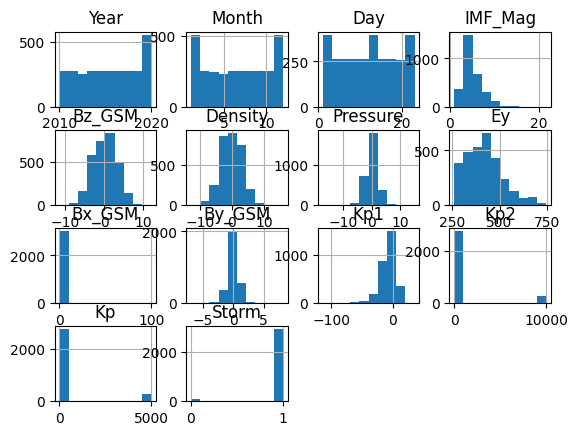

In [13]:
df.hist()

In [14]:
features = ['IMF_Mag', 'Bz_GSM', 'Density', 'Speed', 'Pressure']
X = df[features]
y = df['Storm']

In [15]:


print(df[['Kp', 'Storm'] + features].head())

             Kp  Storm  IMF_Mag  Bz_GSM  Density Speed  Pressure
Datetime                                                        
2010-01-01  4.0      0      3.0    -0.7      2.2   3.8       1.6
2010-01-02  4.0      0      3.0    -0.6      2.5   3.8       1.2
2010-01-03  2.5      0      3.0    -0.4      2.6   3.8       1.0
2010-01-04  1.5      0      2.9    -0.4      2.8   3.7       0.3
2010-01-05  2.5      0      3.0    -0.2      2.5   3.5       1.3


In [16]:
print( X)

            IMF_Mag  Bz_GSM  Density Speed  Pressure
Datetime                                            
2010-01-01      3.0    -0.7      2.2   3.8       1.6
2010-01-02      3.0    -0.6      2.5   3.8       1.2
2010-01-03      3.0    -0.4      2.6   3.8       1.0
2010-01-04      2.9    -0.4      2.8   3.7       0.3
2010-01-05      3.0    -0.2      2.5   3.5       1.3
...             ...     ...      ...   ...       ...
2020-12-19      3.2     1.8     -2.1   2.3       0.8
2020-12-20      3.2     0.8     -2.5   2.7       0.3
2020-12-21      3.0    -0.9     -2.3   2.9      -0.8
2020-12-22      3.3     2.7     -1.7   2.2      -0.2
2020-12-23      3.4     2.8     -1.6   2.0      -0.2

[3014 rows x 5 columns]


In [17]:
print(y)

Datetime
2010-01-01    0
2010-01-02    0
2010-01-03    0
2010-01-04    0
2010-01-05    0
             ..
2020-12-19    1
2020-12-20    1
2020-12-21    1
2020-12-22    1
2020-12-23    1
Name: Storm, Length: 3014, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
print(X_train)

            IMF_Mag  Bz_GSM  Density Speed  Pressure
Datetime                                            
2012-06-19      6.4     3.9      2.1   6.8      -3.1
2018-02-08      3.4    -0.1      3.2   6.1       0.6
2019-09-13      3.9     1.8     -2.5   7.7       1.5
2020-09-18      6.3    -3.4     -2.4   5.1      -3.5
2019-01-20      3.5    -3.4     -0.4   1.8      -0.4
...             ...     ...      ...   ...       ...
2013-07-11      5.7     4.2     -1.2   6.7       3.2
2017-02-08      3.4    -1.2     -0.9   5.9      -2.8
2019-01-07      5.0    -0.5      3.5   4.3      -3.2
2010-11-07      6.3    -2.2      2.3  32.1      -1.7
2015-07-22      7.7     1.1     -2.2  12.7      -3.4

[2411 rows x 5 columns]


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [22]:
y_pred = model.predict(X_test_scaled)


In [23]:
from sklearn.metrics import classification_report, confusion_matrix


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
[[  2  17]
 [  1 583]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.1053    0.1818        19
           1     0.9717    0.9983    0.9848       584

    accuracy                         0.9701       603
   macro avg     0.8192    0.5518    0.5833       603
weighted avg     0.9621    0.9701    0.9595       603



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)


y_pred = model.predict(X_test_scaled)
print("✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


✅ Classification Report:
              precision    recall  f1-score   support

           0     0.2059    0.3684    0.2642        19
           1     0.9789    0.9538    0.9662       584

    accuracy                         0.9353       603
   macro avg     0.5924    0.6611    0.6152       603
weighted avg     0.9546    0.9353    0.9441       603

🧾 Confusion Matrix:
[[  7  12]
 [ 27 557]]


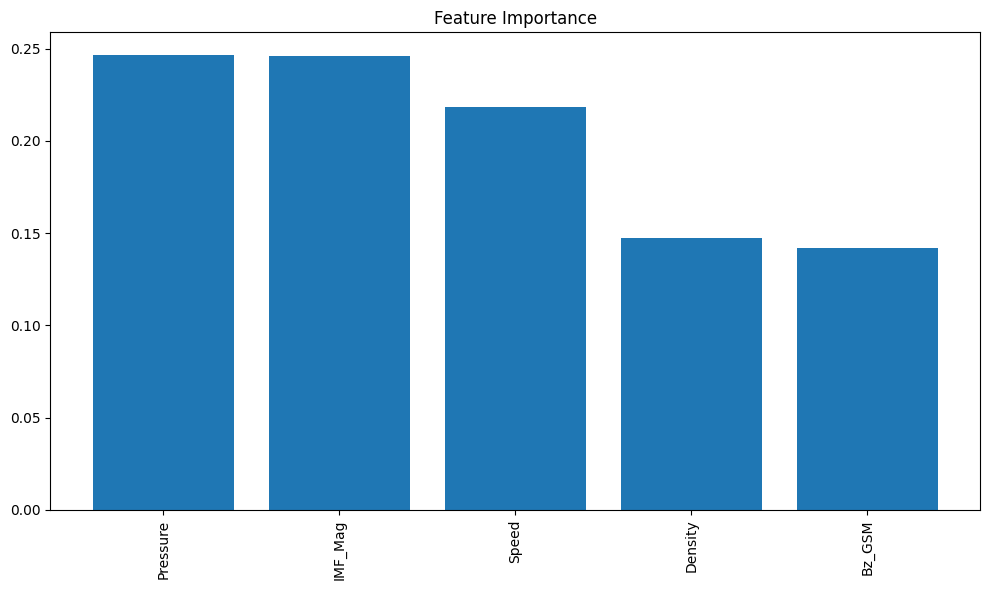

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'storm_classifier.pkl')




['storm_classifier.pkl']

In [ ]:
import pandas as pd

def predict_storm(new_data, model_path='storm_classifier.pkl'):
    model = joblib.load(model_path)
    prediction = model.predict(new_data)
    return prediction


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

# Save it
joblib.dump(pipeline, 'storm_pipeline.pkl')


['storm_pipeline.pkl']

In [29]:
pipeline = joblib.load('storm_pipeline.pkl')
y_pred = pipeline.predict(X_test)


In [30]:
import joblib

storm_model = joblib.load("storm_classifier.pkl")
